# Deep Learning - CNN - MNIST fashion dataset

This notebook provides **convolutional neural networks, or CNNs** examples on fashion-mnist dataset. It uses [Keras](https://keras.io/) to build CNN and get the dataset from here [fashion-mnist](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/).

In [5]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

from keras.utils import np_utils
from keras.utils.data_utils import get_file

import matplotlib.pyplot as plt

import gzip
import os
import numpy as np

np.random.seed(123)

### Dataset
Run the following command to download the dataset.  The first time you run this it will take while as it's pulling the data down over the network.

In [6]:

def load_data():
    dirname = os.path.join('datasets', 'images-dataset')
    base = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

    paths = []
    for file in files:
        paths.append(get_file(file, origin=base + file, cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8,
                                offset=16).reshape(len(y_train), 28, 28, 1)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(len(y_test), 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)


In [7]:

(x_train, y_train), (x_test, y_test) = load_data()

Let's see how the data is formatted by printing the dimensionalities of the variables (tensors).

In [12]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (60000, 28, 28, 1)
y_train (60000,)
x_test (10000, 28, 28, 1)
y_test (10000,)


Above you can see we have 60000 samples of 28x28 images in `x_train`. The third dimension of the images is just 1 as there is just a single grayscale value. The test set is formatted in the same way, except we have just 10000 samples.

The class labels are stored in `y_train`. Let's print the first 10 values just to see what they are...

In [13]:
print(y_train[:10])

[9 0 0 3 0 2 7 2 5 5]


These are the correct classes for each image.  These actually refer to different types of clothing.  Let's define the mapping from class indices to human-understandable labels as a Python dictionary. We have 10 classes, i.e., 10 categories of images to classify.

In [14]:
num_classes = 10

labels = {
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'
}

So, according to this the first image is of class 9, which is an "Ankle boot". Let's look at the first image.

In [15]:
img0 = x_train[0, :, :].reshape(28, 28)
print(img0)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

That's pretty hard to decipher. Let's instead draw it as an image, interpreting each number as a grayscale value.

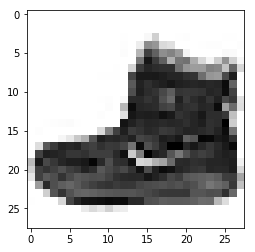

In [17]:
plt.imshow(img0, cmap='Greys', interpolation='none')


Typically we use so called one-hot encoding for the class labels in neural networks.  That is instead of having a single value which can have one of 10 label values (e.g. 0, ..., 9), we have 10 values which can each be 1 or 0 depending on if that class is present. 

Then for the output we typically expect something that looks like a probability distribution over these 10 classes, i.e., each neuron has a value between 0 and 1 indicating the probability of that class being present. For example if the tenth (last) neuron is 0.8, then we have 80% probability of the image containing an ankle boot. (The sum over all classes should also be 1.0 in order for it be a probability distribution.)

Here we'll call a utility function to transform the class labels into a one-hot encoding format.

In [18]:
print("Old format", y_train[:5])
y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)
print("One-hot encoding\n", y_train_cat[:5,])

Old format [9 0 0 3 0]
One-hot encoding
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


You can take a look at the output above. For example for the first image, which has label 9, the tenth value is 1, the rest are zero.

Let's display the first example image of each class just for fun.

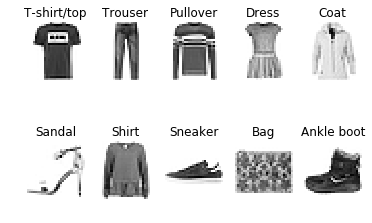

In [20]:
for l in range(10):
    idx = np.argwhere(y_train==l)[0]
  
    plt.subplot(2, 5, l+1)

    img = x_train[idx,:,:].reshape(28,28)

    plt.imshow(img, cmap='Greys', interpolation='none')
    plt.title(labels[l])
    plt.axis('off')

Finally, we normalize the images to be in the range 0.0 to 1.0 instead of 0 to 255.

In [21]:
x_train = x_train/255
x_test = x_test/255

### Simple CNN

Simple CNN that learns to detect these classes. It has (in order):

- One 2D convolutional layer with kernel size 3x3 and 32 output filters/features

- ReLU activation

- Max pooling (2D) of size 2x2

- Fully-connected (dense) layer to 10 output units (for the 10 classes)

- Finally softmax activation to get a probability-like output.

Before the dense layer we need a `Flatten()` layer. This is a special layer in Keras that transforms the 2D output into 1D. The 2D convolution works with neurons in 2D, but the dense layer works in 1D.

In [11]:
# Initialize model
model = Sequential()

units_output = 10

# Add layers here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

#model.add(Dense(10, activation='softmax'))

# Let's use categorical crossentry and sgd optmizer
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  


### Training

Now let's train it for 10 epochs. This takes roughly 5 minutes on a CPU.

We use a batch size of 128, which means that the weight updates are calculated for 128 inputs at a time.

In [12]:
%%time

epochs = 10 # one epoch typically takes a minute or two

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 21s - loss: 1.0394 - acc: 0.6644    
Epoch 2/10
60000/60000 [==============================] - 21s - loss: 0.6091 - acc: 0.7872    
Epoch 3/10
60000/60000 [==============================] - 21s - loss: 0.5489 - acc: 0.8053    
Epoch 4/10
60000/60000 [==============================] - 21s - loss: 0.5239 - acc: 0.8136    
Epoch 5/10
60000/60000 [==============================] - 21s - loss: 0.5012 - acc: 0.8233    
Epoch 6/10
60000/60000 [==============================] - 20s - loss: 0.4876 - acc: 0.8279    
Epoch 7/10
60000/60000 [==============================] - 21s - loss: 0.4752 - acc: 0.8326    
Epoch 8/10
60000/60000 [==============================] - 20s - loss: 0.4623 - acc: 0.8382    
Epoch 9/10
60000/60000 [==============================] - 20s - loss: 0.4543 - acc: 0.8397    
Epoch 10/10
60000/60000 [==============================] - 22s - loss: 0.4469 - acc: 0.8441    
CPU times: user 6min 29s, sys: 1min 24s, total: 7

Let's plot how the loss and accuracy have changed over the training time.

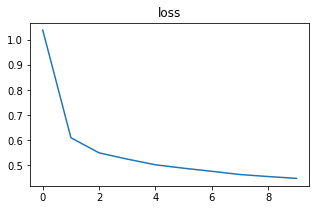

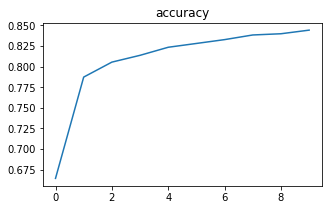

In [13]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')


### Inference
Let's predict the labels of the test dataset, and compare to the correct labels.

In [14]:
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.80%


### Visualise the weights

An interesting thing is to visualise the learned weights for the convolutional layer.  We have 32 kernels of size 3x3, we can just plot them as images, mapping the weight values to grayscale.

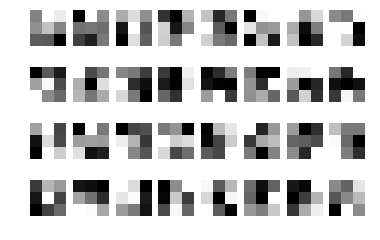

In [15]:
# Weights for the first convolutional layer
w0=model.get_weights()[0][:,:,0,:]

# Normalize to range 0.0 - 1.0
w0 -= np.min(w0)
w0 /= np.max(w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(w0[:,:,n], interpolation='none')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems these weights have learned to detect various corners and edges.

## Making a better CNN 

Make a network that performs better than the very simple one above. Example parameters that needs to be change: 

- number of layers or neurons
- activation functions
- epochs
- batch sizes
- optimizer, see [Keras' documentation on optimizers](https://keras.io/optimizers/)
- max-pooling on/off on certain layers

In [7]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

from keras.utils import np_utils
import matplotlib.pyplot as plt

# Load the dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Normalize
x_train = x_train/255
x_test = x_test/255

num_classes = 10

y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                46090     
__________

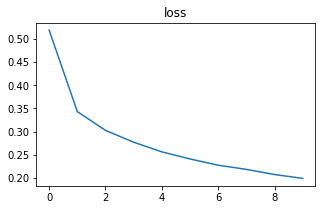

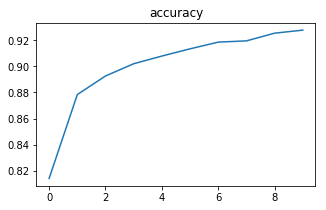

In [23]:
np.random.seed(123)
model = Sequential()
units_output = 10

# Add model here
# Convolutional layer with kernel size 3x3 and 32 output filters
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(32, 3, 3, activation='relu'))

# ReLU activation
model.add(Activation('relu'))

# Max pooling (2D) of size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten 2D output into 1D
model.add(Flatten())

# Dense layer to 10 output units
model.add(Dense(units=units_output))

# softmax activation
model.add(Activation('softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())


# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### Improvements/Reparameterizations:

In this reparameterizations, model includes one more Convolution layer with kernel size (3x3) and 32 output filters. Moreover, model also contains two Dropout layers with 0.25 and 0.5 percertage respectively to avoid overfitting. 

This model uses "adam" optimizer instead of "sgd". 

Overall accuracy obtained on test set is 91.76%. Which is 7.88% better then the previous exercise's network.